# Scanpy Study

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

%config InlineBackend.figure_format = 'retina'

sc.settings.set_figure_params(dpi=50, dpi_save=300, figsize=(4,4))

## load data

### method one

In [3]:
adata = sc.read_10x_mtx('/Users/yanyucheng/Desktop/RNA_seq/data/filtered_gene_bc_matrices/GSM6614348_HC-1/', var_names = 'gene_symbols', cache = True)
# adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 737280 × 33538
    var: 'gene_ids', 'feature_types'

### method two

In [4]:
obs = pd.read_csv('/Users/yanyucheng/Desktop/RNA_seq/data/filtered_gene_bc_matrices/GSM6614348_HC-1/barcodes.tsv', header=None, index_col=0, sep='\t')
var = pd.read_csv('/Users/yanyucheng/Desktop/RNA_seq/data/filtered_gene_bc_matrices/GSM6614348_HC-1/features.tsv', header=None, index_col=1, sep='\t')
obs.index.name = ''
var.index.name = ''
var.columns = ['gene_ids','feature_types']

from scipy.io import mmread
from scipy.sparse import csr_matrix
mtx = mmread('/Users/yanyucheng/Desktop/RNA_seq/data/filtered_gene_bc_matrices/GSM6614348_HC-1/matrix.mtx')
mtx = mtx.T
mtx = csr_matrix(mtx)
adata1 = sc.AnnData(mtx, obs = obs, var = var)

/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata1.var_names_make_unique()

In [6]:
adata1

AnnData object with n_obs × n_vars = 737280 × 33538
    var: 'gene_ids', 'feature_types'

## QC

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

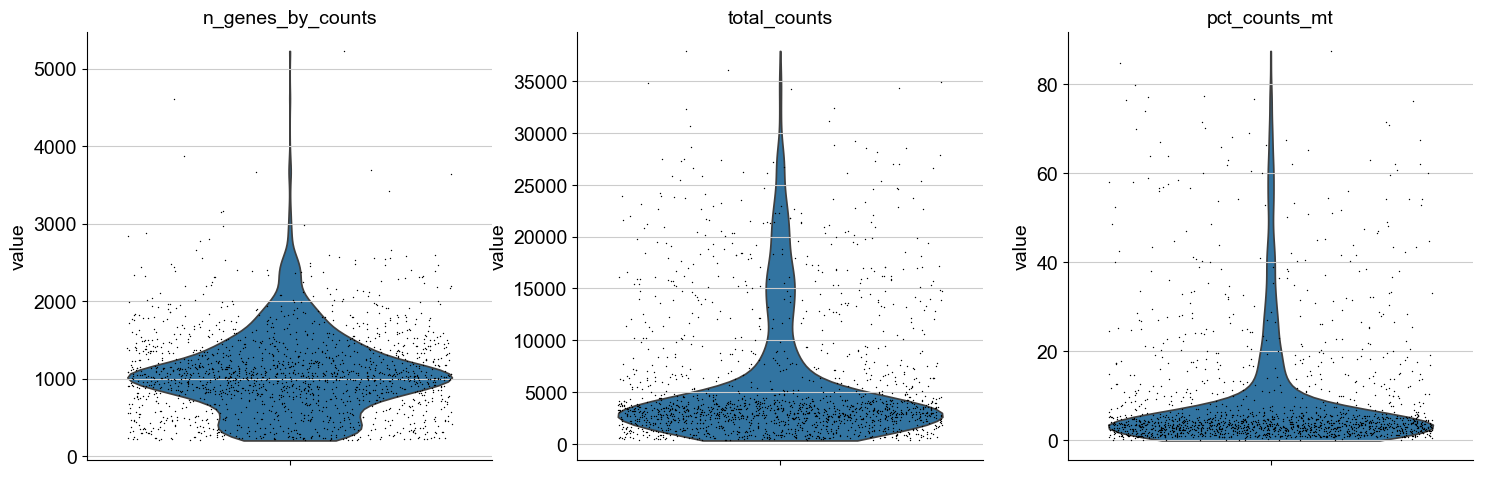

In [8]:
sc.pl.violin(adata,['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

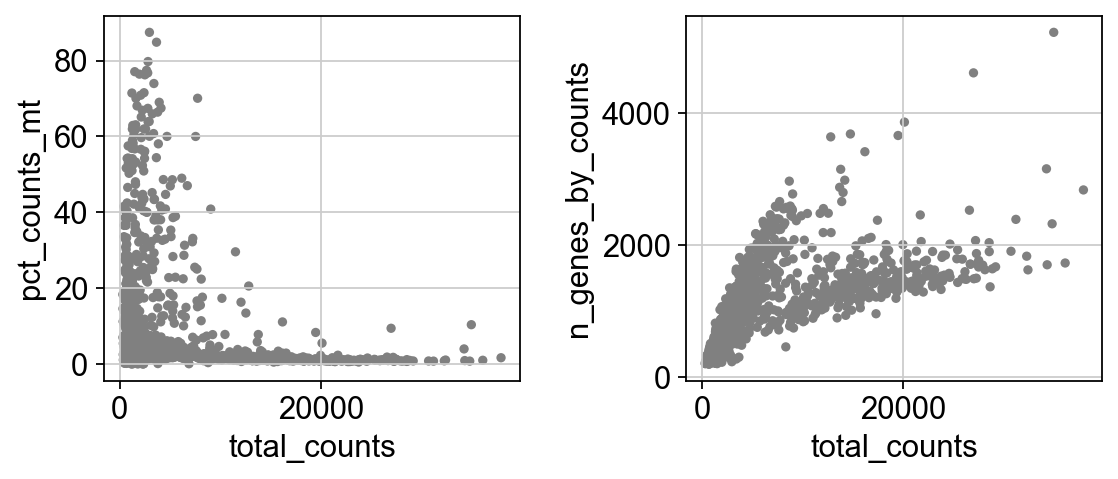

In [9]:
sc.settings.set_figure_params(dpi_save=300)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax=ax[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax=ax[1], show=False)
plt.subplots_adjust(wspace=.4)

In [10]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

## Normalization

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/opt/anaconda3/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:208: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## feature selection

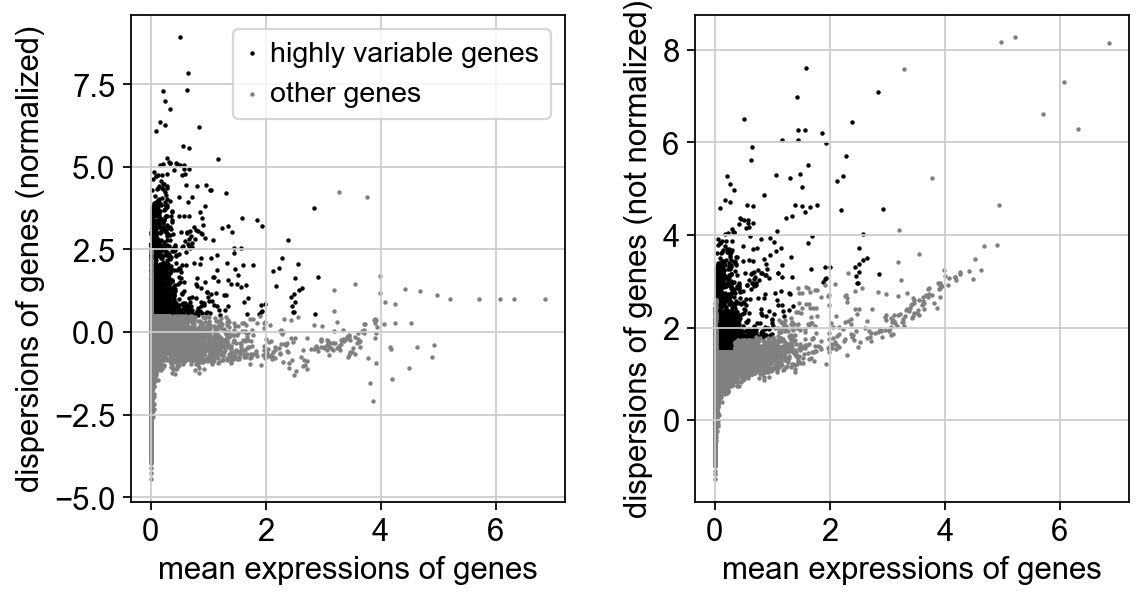

View of AnnData object with n_obs × n_vars = 1102 × 2966
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [12]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata.raw = adata
adata[:, adata.var.highly_variable]

In [13]:
sc.pp.regress_out(adata, ['total_counts','pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/opt/anaconda3/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:647: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff
/opt/anaconda3/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:647: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  data[i] -= regressor[i] @ coeff


### reduction

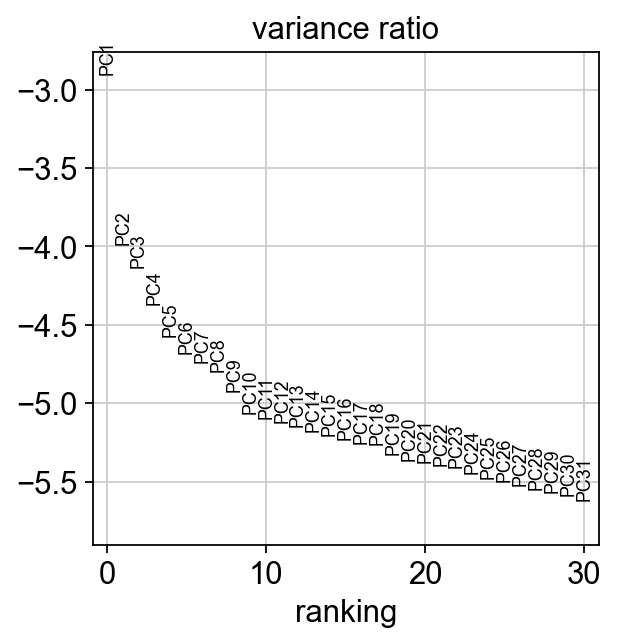

In [14]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

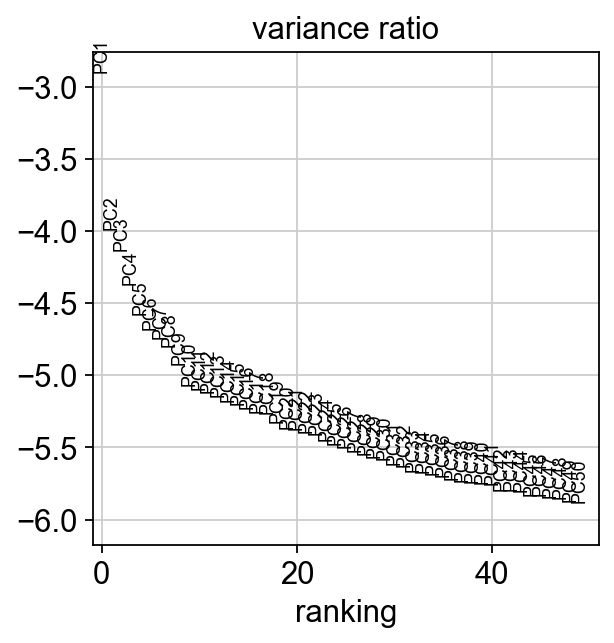

In [15]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

In [16]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

### Clustering

In [23]:
sc.tl.leiden(adata,flavor="igraph", n_iterations=2, directed=False)

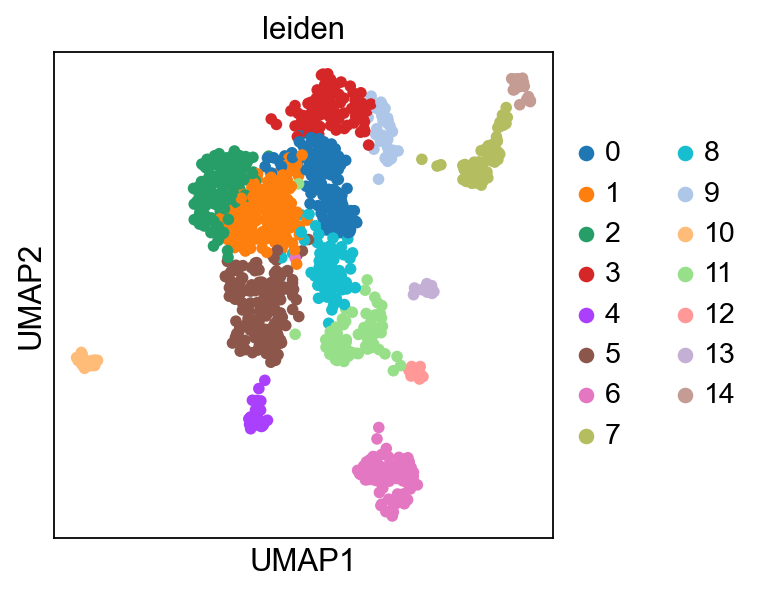

In [24]:
sc.pl.umap(adata, color='leiden')

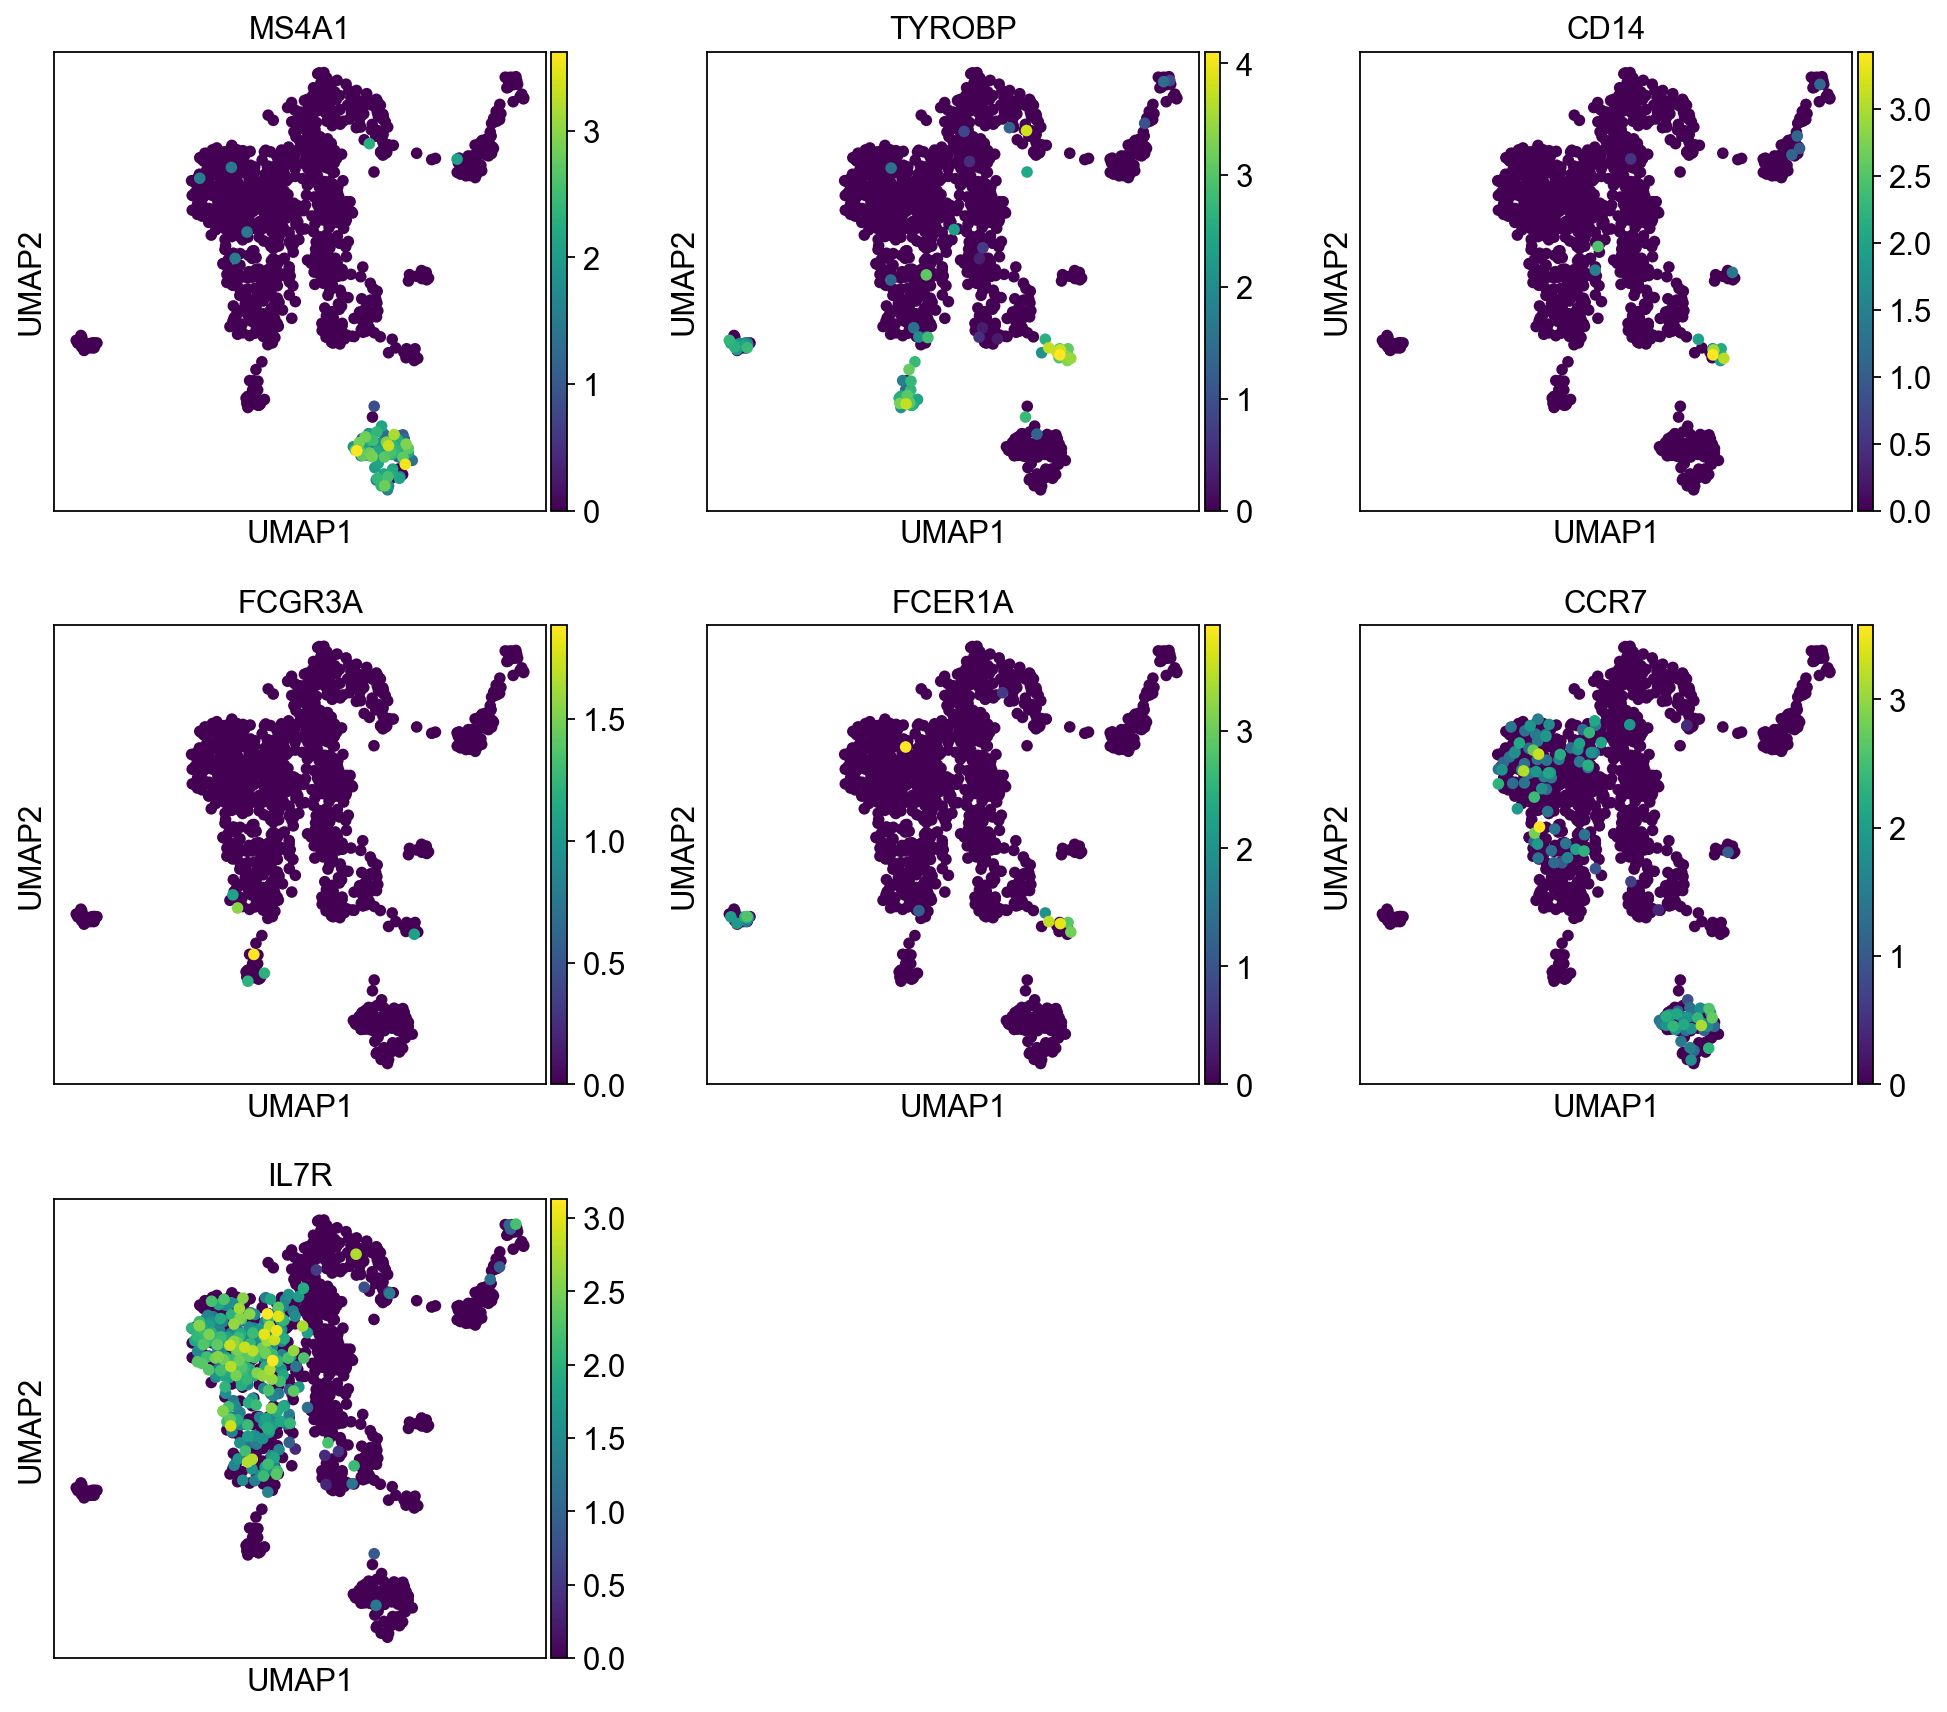

In [29]:
markers = ["MS4A1", "TYROBP", "CD14", 'FCGR3A', "FCER1A", "CCR7", "IL7R"]
sc.pl.umap(adata, color=markers, ncols=3)

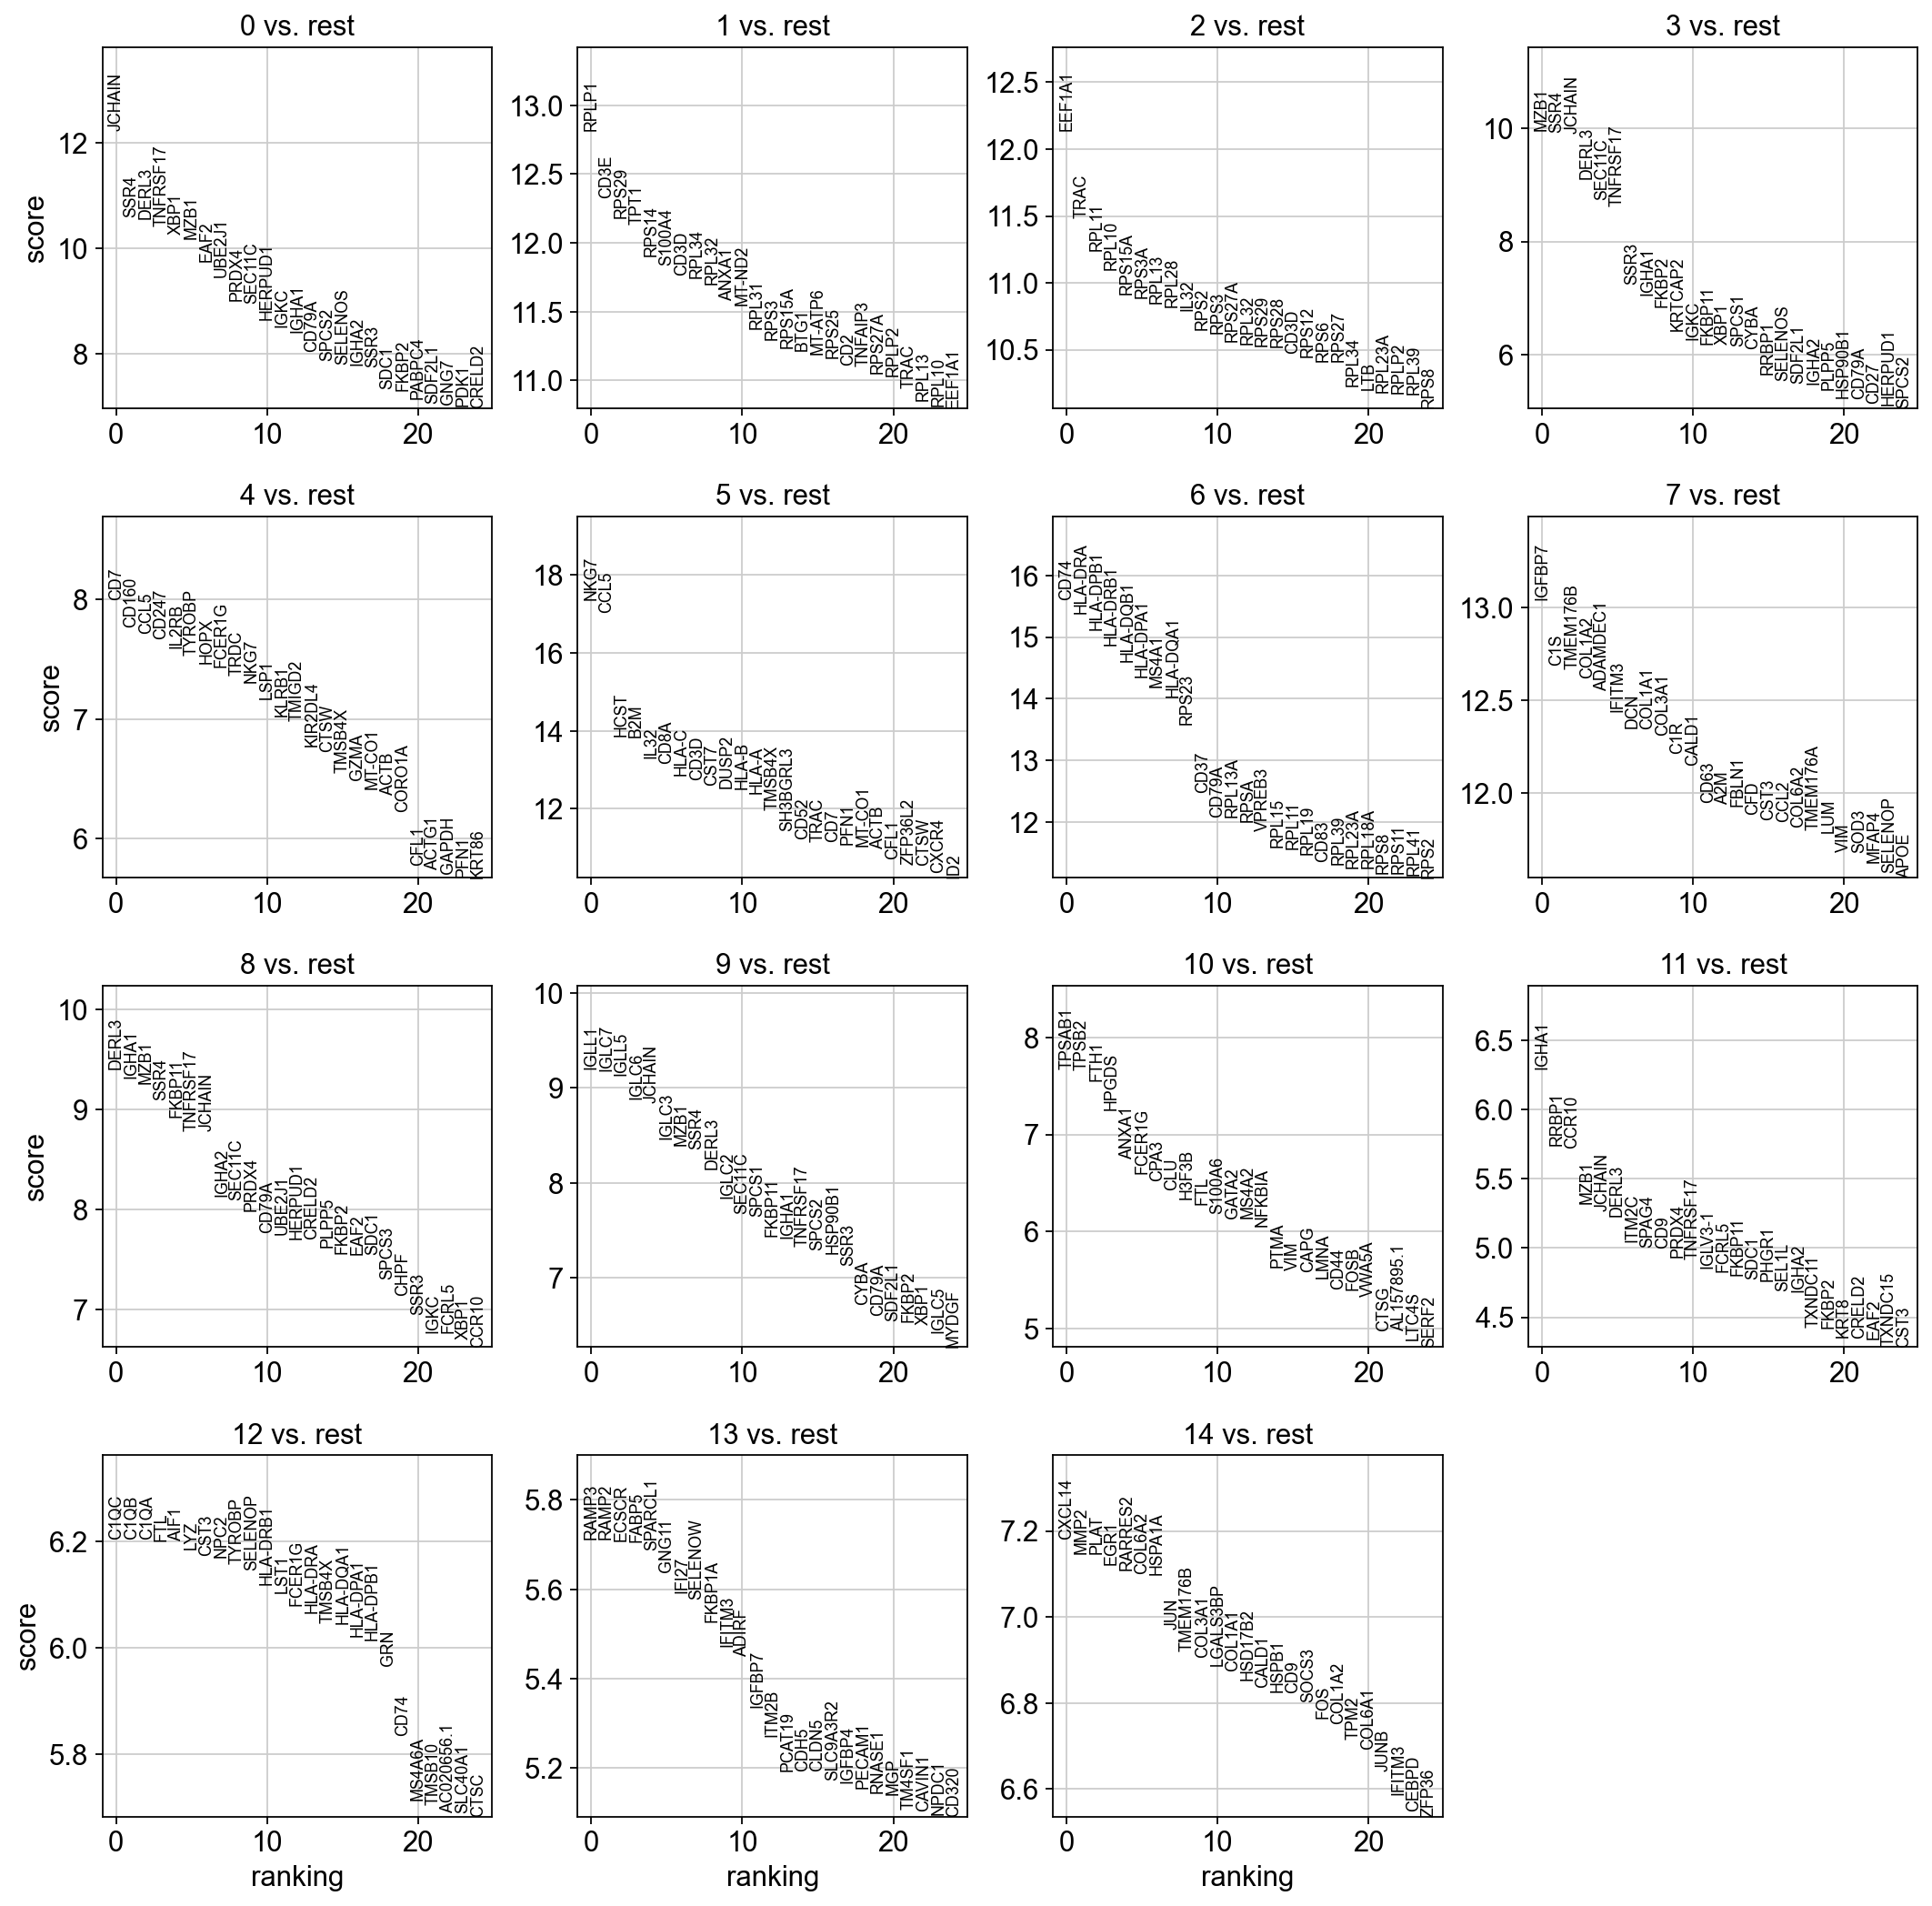

In [30]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [34]:
new_cluster_names = ['CD4 T','CD14 Monocytes','B','CD8 T','FCGR3A Monocytes','NK','DC','Platelet','a','b','c','d','e','f','g']
adata.rename_categories('leiden', new_cluster_names)

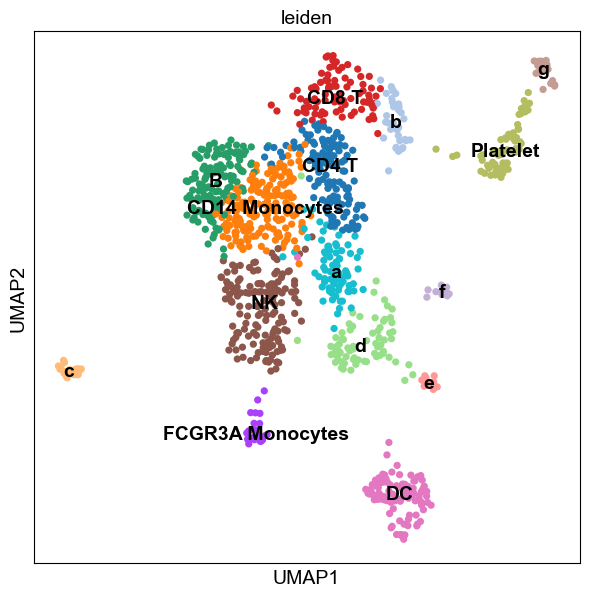

In [35]:
sc.settings.set_figure_params(dpi=50, dpi_save=300, figsize=(7,7))
sc.pl.umap(adata, color='leiden', legend_loc='on data')

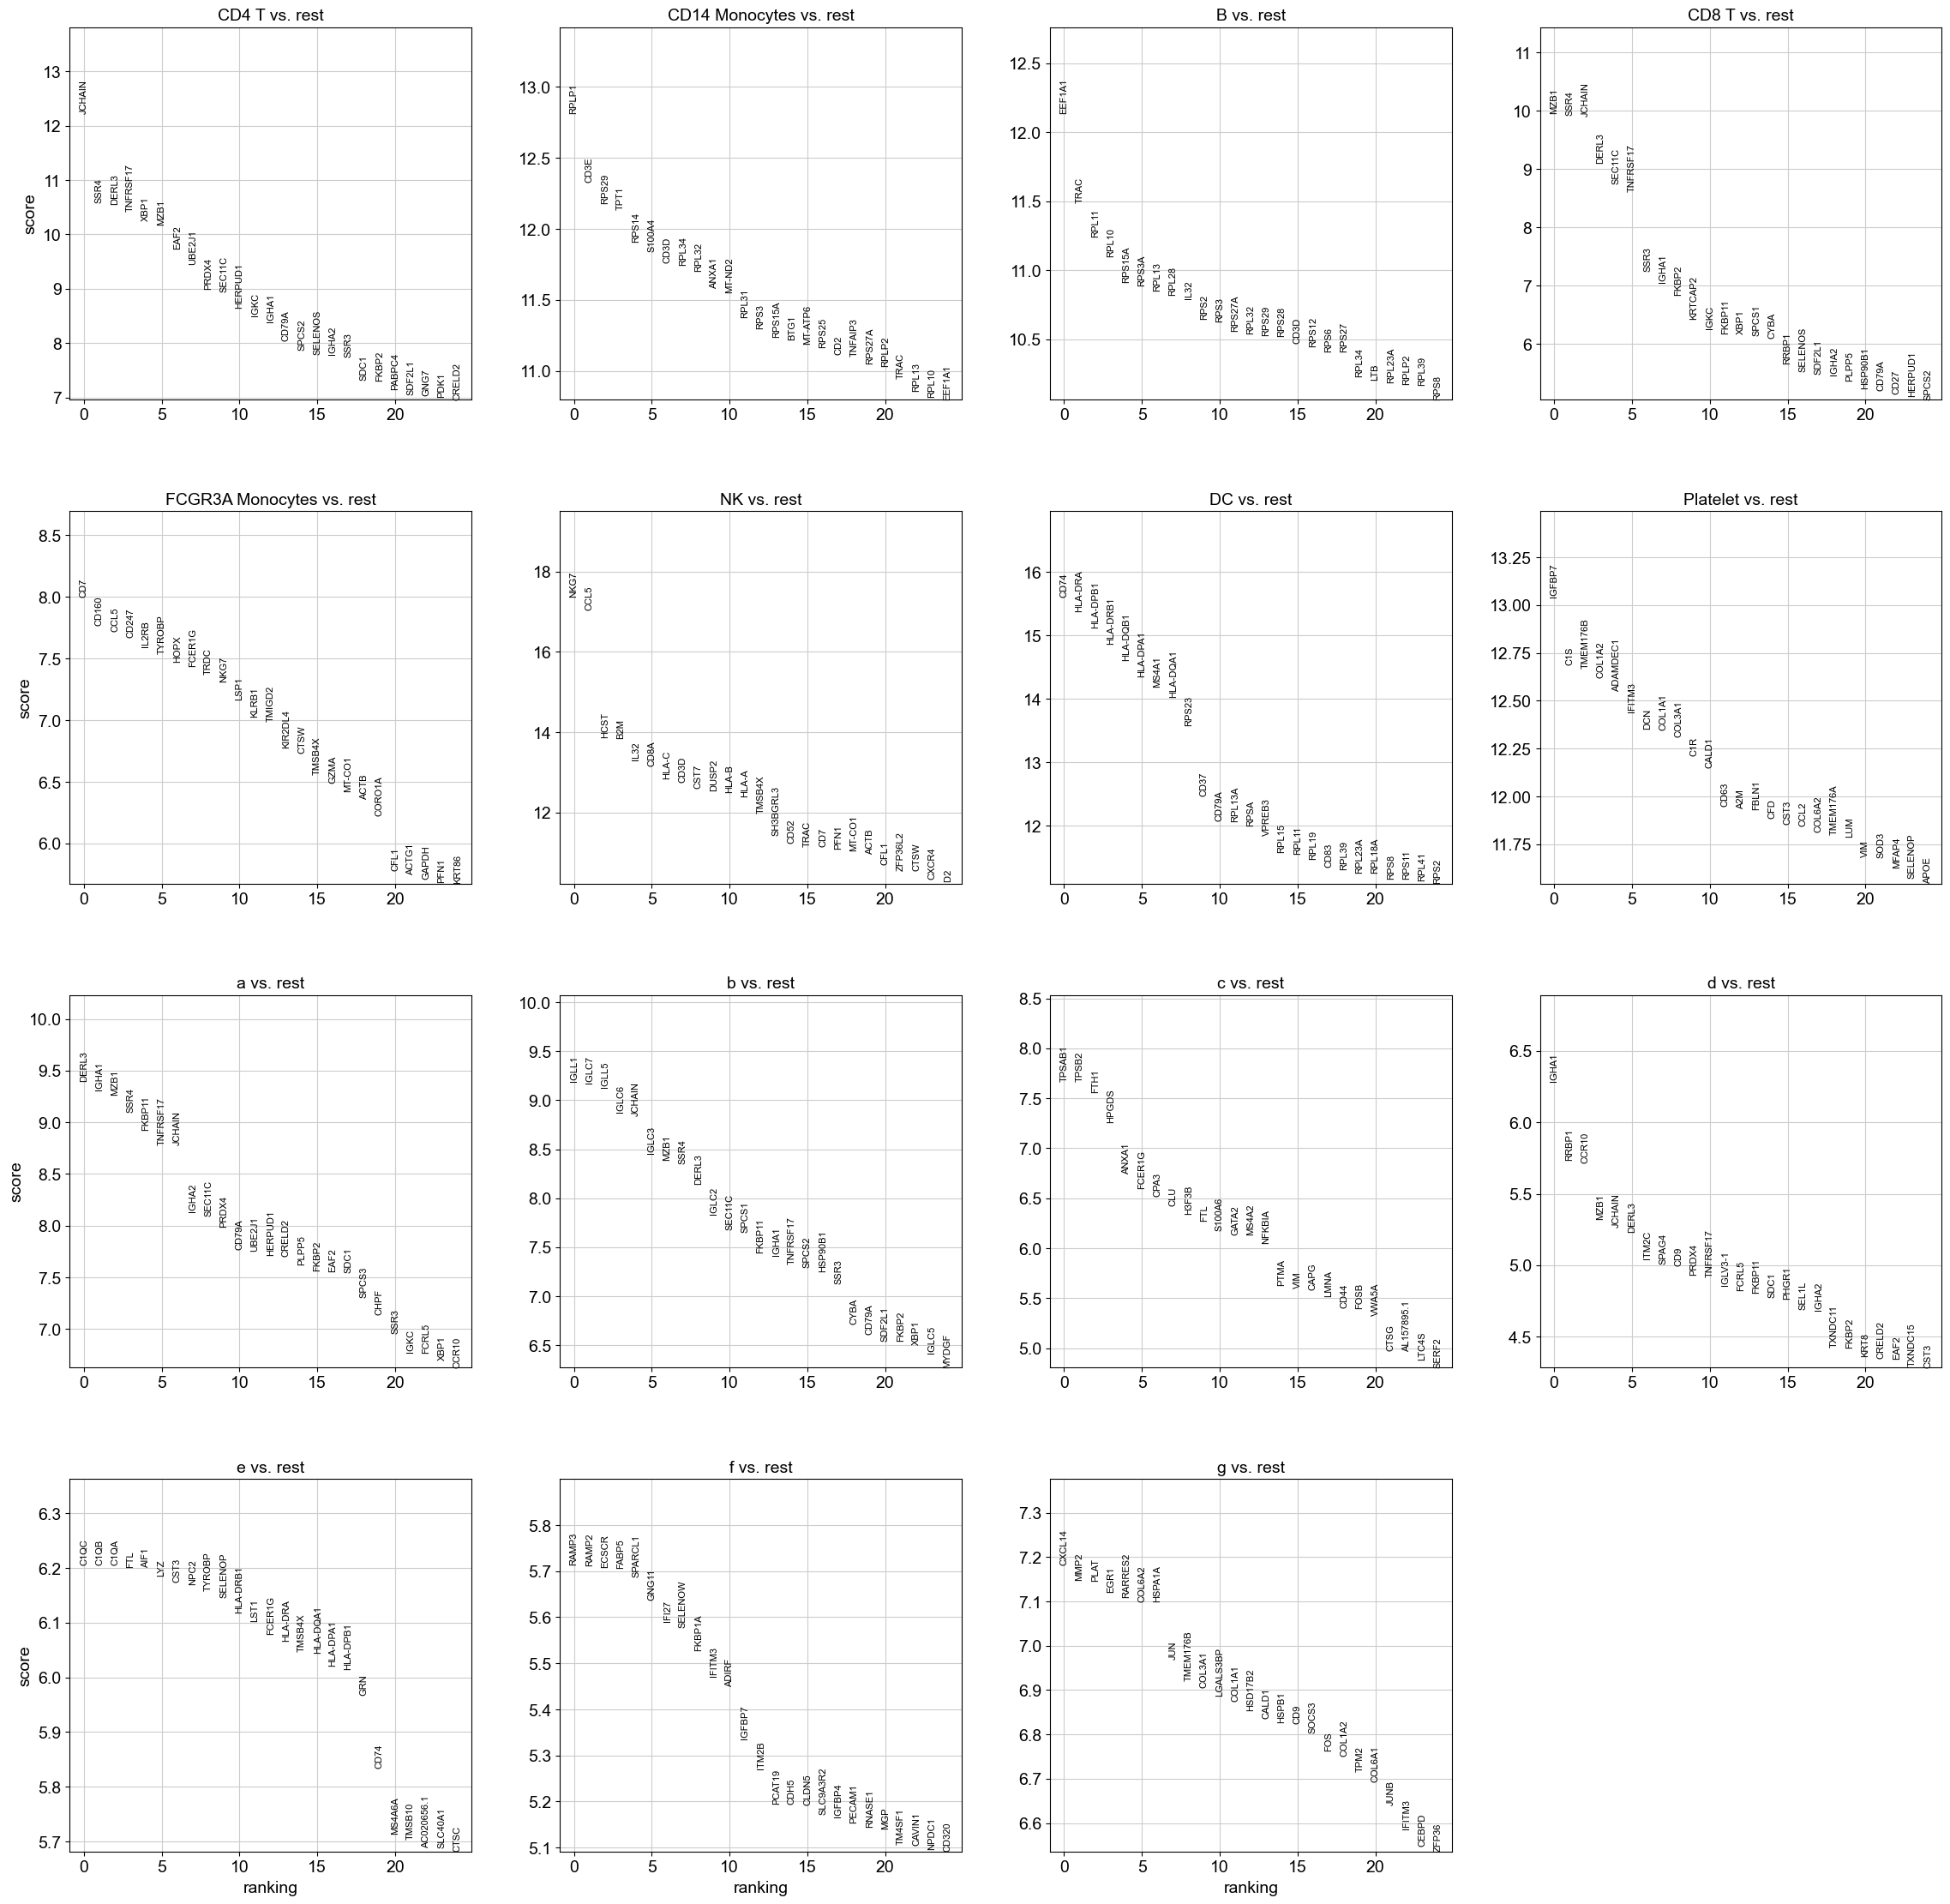

In [36]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [69]:
?sc.tl.rank_genes_groups

Signature:
sc.tl.rank_genes_groups(
    adata: 'AnnData',
    groupby: 'str',
    *,
    mask_var: 'NDArray[np.bool_] | str | None' = None,
    use_raw: 'bool | None' = None,
    groups: "Literal['all'] | Iterable[str]" = 'all',
    reference: 'str' = 'rest',
    n_genes: 'int | None' = None,
    rankby_abs: 'bool' = False,
    pts: 'bool' = False,
    key_added: 'str | None' = None,
    copy: 'bool' = False,
    method: '_Method | None' = None,
    corr_method: '_CorrMethod' = 'benjamini-hochberg',
    tie_correct: 'bool' = False,
    layer: 'str | None' = None,
    **kwds,
) -> 'AnnData | None'
Docstring:
Rank genes for characterizing groups.

Expects logarithmized data.

Parameters
----------
adata : 'AnnData'
    Annotated data matrix.
groupby : 'str'
    The key of the observations grouping to consider.
mask_var : 'NDArray[np.bool_] | str | None', optional (default: None)
    Select subset of genes to use in statistical tests.
use_raw : 'bool | None', optional (default: None)
    

## Understand the data structure of Anndata

In [37]:
adata

AnnData object with n_obs × n_vars = 1102 × 16052
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [38]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACCTGAGGTCGGAT-1,1387,1382,13508.0,220.0,1.628664,CD4 T
AAACCTGCAAGTCTGT-1,676,674,2055.0,86.0,4.184915,CD14 Monocytes
AAACGGGGTCTAGCCG-1,962,959,2933.0,91.0,3.102625,CD14 Monocytes
AAAGATGCACACCGAC-1,716,716,6587.0,160.0,2.429027,CD8 T
AAAGATGCAGGATCGA-1,1451,1447,3948.0,190.0,4.812563,FCGR3A Monocytes
...,...,...,...,...,...,...
TTTGCGCAGTGGGTTG-1,797,794,2286.0,0.0,0.000000,d
TTTGCGCCAAGCCGCT-1,2382,2379,17435.0,262.0,1.502724,a
TTTGCGCGTACGCACC-1,1178,1177,2891.0,125.0,4.323763,FCGR3A Monocytes
TTTGTCAAGCTTATCG-1,1273,1273,4082.0,142.0,3.478687,NK


In [39]:
adata.var

,gene_ids,feature_types,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
AL627309.1,ENSG00000238009,Gene Expression,3,False,3,0.001761,99.823944,3.0,False,0.002485,0.163714,-1.863423,-2.794757e-12,0.034689
AL669831.5,ENSG00000237491,Gene Expression,33,False,33,0.019366,98.063380,33.0,False,0.035744,0.787675,-0.744536,1.977582e-10,0.141573
LINC00115,ENSG00000225880,Gene Expression,30,False,30,0.018192,98.239437,31.0,True,0.060320,2.068655,1.552520,-3.156524e-10,0.186278
FAM41C,ENSG00000230368,Gene Expression,28,False,28,0.016432,98.356808,28.0,False,0.030781,0.795468,-0.730560,9.681909e-11,0.133637
AL645608.1,ENSG00000223764,Gene Expression,3,False,3,0.001761,99.823944,3.0,False,0.002010,0.796510,-0.728692,-1.079602e-11,0.035196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC007325.4,ENSG00000278817,Gene Expression,16,False,16,0.009390,99.061033,16.0,False,0.021155,1.059131,-0.257760,6.127122e-12,0.112452
AL354822.1,ENSG00000278384,Gene Expression,3,False,3,0.001761,99.823944,3.0,False,0.003379,1.116551,-0.154794,-1.073221e-11,0.045319
AC233755.2,ENSG00000277856,Gene Expression,15,False,15,0.012324,99.119718,21.0,True,0.018574,2.053153,1.524723,6.392213e-11,0.098671
AC233755.1,ENSG00000275063,Gene Expression,6,False,6,0.004108,99.647887,7.0,False,0.006172,1.070298,-0.237734,6.096668e-11,0.058338


In [40]:
adata.uns

OrderedDict([('log1p', {'base': None}),
             ('hvg', {'flavor': 'seurat'}),
             ('pca',
              {'params': {'zero_center': True,
                'use_highly_variable': True,
                'mask_var': 'highly_variable'},
               'variance': array([130.2601   ,  44.061974 ,  38.089985 ,  29.962166 ,  24.429007 ,
                       21.985064 ,  20.69606  ,  19.594923 ,  17.226048 ,  14.968484 ,
                       14.532471 ,  14.186534 ,  13.838514 ,  13.345672 ,  13.060794 ,
                       12.686265 ,  12.400537 ,  12.3291645,  11.528069 ,  11.104844 ,
                       10.991843 ,  10.783361 ,  10.621189 ,  10.199935 ,   9.903366 ,
                        9.744317 ,   9.461189 ,   9.227421 ,   9.042442 ,   8.906016 ,
                        8.604688 ,   8.499161 ,   8.237313 ,   8.181722 ,   8.034983 ,
                        7.951644 ,   7.7922034,   7.6531463,   7.609086 ,   7.576369 ,
                        7.519893 ,   7.2137184,

In [41]:
adata.uns.keys()

odict_keys(['log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'])

In [42]:
adata.uns['hvg']

{'flavor': 'seurat'}

In [43]:
adata.obsm

AxisArrays with keys: X_pca, X_umap

In [44]:
adata.varm

AxisArrays with keys: PCs

In [46]:
adata.varm['PCs'].shape

(16052, 50)

In [47]:
adata.obsp

PairwiseArrays with keys: distances, connectivities